# **Assignment 1 : Part 2 - Mirsaeid Abolghasemi**

## Semi supervised learnign assignment
Pick an appropriate problem domain for semi supervised  learning for which a small data set is readily available, Implement and submit a proper colab with proper ablation study (with various tunings) using tensorboard  for semi supervised  learning. 

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget 'https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'

--2020-09-07 16:49:33--  https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/plain]
Saving to: ‘credit_card.csv’

credit_card.csv     100%[===================>] 143.84M   117MB/s    in 1.2s    

2020-09-07 16:49:42 (117 MB/s) - ‘credit_card.csv’ saved [150828752/150828752]



In [3]:
# Load the data
#current_path = os.getcwd()
#file = os.path.sep.join(['', 'credit_card.csv'])

data = pd.read_csv('credit_card.csv')


In [4]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# Split into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [6]:
# Drop 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [8]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [9]:

def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [10]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)


### Supervised Learning Section

In [11]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}


**Printing Training Log Loss**

**Printing CV Log Loss**
    
**Printing LightGBM Gradient Boosting Log Loss**

In [12]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00501798
[3]	valid_0's binary_logloss: 0.0113596
[4]	valid_0's binary_logloss: 0.0134411
[5]	valid_0's binary_logloss: 0.0120885
[6]	valid_0's binary_logloss: 0.0118795
[7]	valid_0's binary_logloss: 0.0123715
[8]	valid_0's binary_logloss: 0.0112126
[9]	valid_0's binary_logloss: 0.0111943
[10]	valid_0's binary_logloss: 0.0110223
[11]	valid_0's binary_logloss: 0.0119001
[12]	valid_0's binary_logloss: 0.011144
[13]	valid_0's binary_logloss: 0.0108834
[14]	valid_0's binary_logloss: 0.0103315
[15]	valid_0's binary_logloss: 0.010241
[16]	valid_0's binary_logloss: 0.0102127
[17]	valid_0's binary_logloss: 0.0101784
[18]	valid_0's binary_logloss: 0.0101528
[19]	valid_0's binary_logloss: 0.0103359
[20]	valid_0's binary_logloss: 0.0103066
[21]	valid_0's binary_logloss: 0.010272
[22]	valid_0's binary_logloss: 0.0102553
[23]	valid_0's binary_logloss: 0.0102284
[24]

## **Precision-Recall Curve- Train**

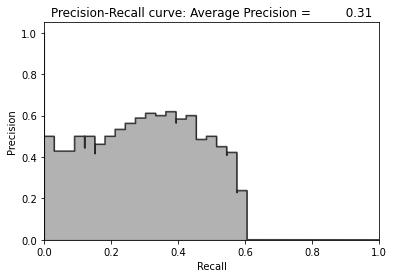

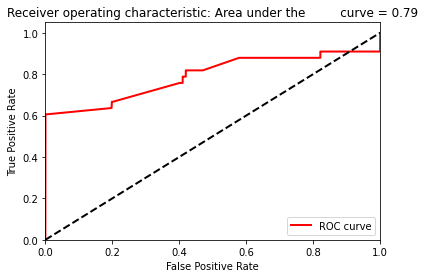

In [13]:
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

## **Precision-Recall Curve- Test**

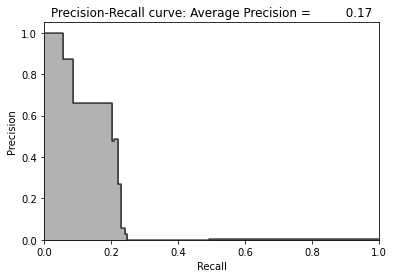

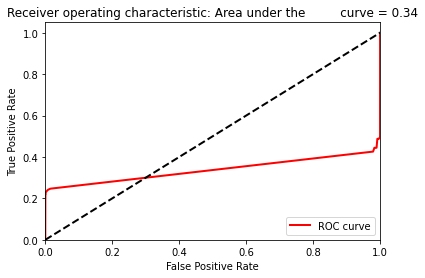

In [14]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [15]:

preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall: ", precision)

Precision at 75% recall:  0.0013093742681343013


# **Unsupervised Learning Section**

In [16]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [17]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [18]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [19]:

num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0766 - accuracy: 0.8650 - val_loss: 0.0304 - val_accuracy: 0.9645
Epoch 2/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0181 - accuracy: 0.9260 - val_loss: 0.0414 - val_accuracy: 0.9481
Epoch 3/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0176 - accuracy: 0.9273 - val_loss: 0.0078 - val_accuracy: 0.9801
Epoch 4/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0169 - accuracy: 0.9281 - val_loss: 0.0163 - val_accuracy: 0.9656
Epoch 5/5
4846/4846 [==============================] - 13s 3ms/step - loss: 0.0175 - accuracy: 0.9266 - val_loss: 0.0149 - val_accuracy: 0.9888


## **Precision-Recall Curve- Train**

5954/5954 [==============================] - 5s 889us/step


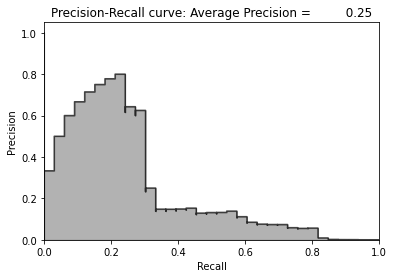

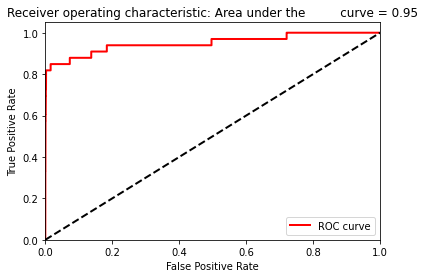

In [20]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

## **Precision-Recall Curve- Test**

2938/2938 [==============================] - 3s 894us/step


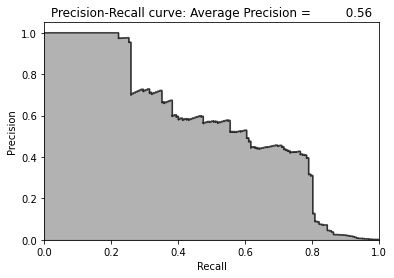

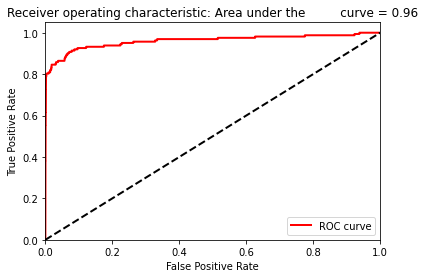

In [21]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [22]:

preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.42560553633217996


# **Semi-supervised Learning Section**

In [23]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [24]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [25]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

**Printing Training Log Loss**

**Printing CV Log Loss**
    
**Printing LightGBM Gradient Boosting Log Loss**

In [26]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00246272
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00215653
[3]	valid_0's binary_logloss: 0.00204708
[4]	valid_0's binary_logloss: 0.00204625
[5]	valid_0's binary_logloss: 0.002044
[6]	valid_0's binary_logloss: 0.00204289
[7]	valid_0's binary_logloss: 0.00204211
[8]	valid_0's binary_logloss: 0.00204135
[9]	valid_0's binary_logloss: 0.00204395
[10]	valid_0's binary_logloss: 0.00204233
[11]	valid_0's binary_logloss: 0.00204108
[12]	valid_0's binary_logloss: 0.00207275
[13]	valid_0's binary_logloss: 0.00226374
[14]	valid_0's binary_logloss: 0.00241374
[15]	valid_0's binary_logloss: 0.00263394
[16]	valid_0's binary_logloss: 0.00263327
[17]	valid_0's binary_logloss: 0.00263259
[18]	valid_0's binary_logloss: 0.00263197
[19]	valid_0's binary_logloss: 0.00263142
[20]	valid_0's binary_logloss: 0.00263061
[21]	valid_0's binary_logloss: 0.00262991
[22]	valid_0's binary_logloss: 0.00262919
[23]	valid_0's binary_lo

## **Precision-Recall Curve- Train**

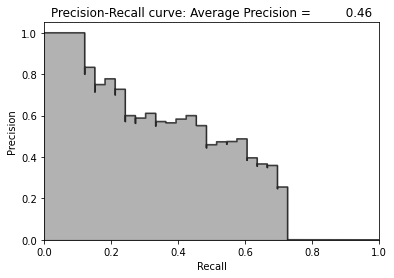

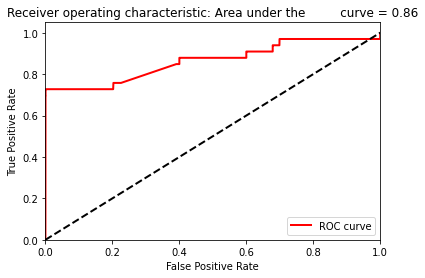

In [27]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

## **Precision-Recall Curve- Test**

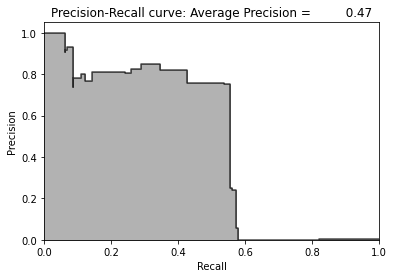

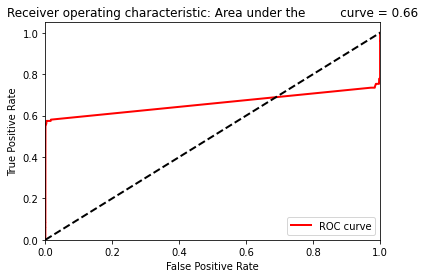

In [28]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

Finding the precision

In [29]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.0013136394219986542


In [30]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
22,0.121212
V7,0.090909
V24,0.090909
31,0.090909
V1,0.060606
...,...
4,0.000000
V2,0.000000
6,0.000000
7,0.000000


In [31]:
featuresImportance.shape

(69, 1)